In [79]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interp
import sklearn as sk
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

In [98]:
def get_collinearity(data):
    #X = data[['listening_days','lifetime','num_albums','num_songs','num_artists','num_playlists','user_stream_count','first_day','age']]
    corr = data.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,annot=False,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def remove_high_corr(data, tresh, viz=False):  
    if viz==True:
        check_multicollinearity(data)
        
    cor = data.corr()[(abs(data.corr()) >= tresh) & (data.corr() != 1)].dropna(how='all').dropna(axis=1,how='all')
    
    cor_list1 = []
    cor_list2 = []

    for id1 in cor.index.tolist():
        for id2 in cor.index.tolist():
            if (~np.isnan(cor[id1][id2])):
            
                cor_list1.append(id1)
                cor_list2.append(id2)
                
    full = data.corr().Attrition
    drop_list = []

    for i in range(0, len(cor_list1)):
        id1 = cor_list1[i]
        id2 = cor_list2[i]
    
        val1 = full[id1]
        val2 = full[id2]
    
        if (np.isnan(val1) | np.isnan(val2)):
            pass
    
        if((val1 > val2) & (val1 not in drop_list)):
            drop_list.append(id1)
        elif (val2 not in drop_list):
            drop_list.append(id2)
        
    drop_list = list(filter(lambda i: i != 'Attrition', drop_list))
    print('\ndropping collinear columns', drop_list)
    data = data.drop(drop_list,axis=1)
    print('final columns list: ', data.columns)
    return data
    
    
def set_binary(r):
    if r =='Yes':
        r=1
    elif r=='No':
        r=0
    return r

def get_bins(data):
    data['age_bin'] = pd.cut(data['Age'], [17, 25, 40, 61], labels=['young adult', 'adult','old'])
    data['distance_bin'] = pd.cut(data['DistanceFromHome'],[0,3,10,31],labels = ['1km','within 10km','>10km'])
    data = data.drop(['Age','DistanceFromHome'], axis=1)
    return data

def convert_to_category(r):
    if r==1:
        r='Low'
    elif r==2:
        r='Medium'
    elif r==3:
        r='High'
    elif r==4:
        r='Very High'
    return r

def get_dummies(train_df):
    dept = pd.get_dummies(train_df['Department'], drop_first=True)
    edu_field = pd.get_dummies(train_df['EducationField'], drop_first=True)
    travel = pd.get_dummies(train_df['BusinessTravel'], drop_first=True)
    gender = pd.get_dummies(train_df['Gender'], drop_first=True)
    job_role = pd.get_dummies(train_df['JobRole'], drop_first=True)
    married = pd.get_dummies(train_df['MaritalStatus'], drop_first=True)
    overtime = pd.get_dummies(train_df['OverTime'], drop_first=True)
    age_bins = pd.get_dummies(train_df['age_bin'], drop_first=True)
    distance_bins = pd.get_dummies(train_df['distance_bin'], drop_first=True)
    # concat dummies to df
    train_new = pd.concat([train_df, dept], axis=1)
    train_new = pd.concat([train_new, edu_field], axis=1)
    train_new = pd.concat([train_new, travel], axis=1)
    train_new = pd.concat([train_new, gender], axis=1)
    train_new = pd.concat([train_new, job_role], axis=1)  
    train_new = pd.concat([train_new, married], axis=1)
    train_new = pd.concat([train_new, distance_bins], axis=1)
    train_new = pd.concat([train_new, age_bins], axis=1)
    # remove the categorical columns
    train_new = train_new.drop(['Department', 'EducationField','BusinessTravel','Gender',
                                'JobRole','MaritalStatus','OverTime','age_bin','distance_bin'],axis=1)
    return train_new


In [90]:
df = pd.read_csv('employee-attrition.csv')

In [91]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [92]:
len(df.columns), df.columns

(35, Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
        'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
        'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
        'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'],
       dtype='object'))

In [94]:
df.groupby('DistanceFromHome')['DistanceFromHome'].count()

DistanceFromHome
1     208
2     211
3      84
4      64
5      65
6      59
7      84
8      80
9      85
10     86
11     29
12     20
13     19
14     21
15     26
16     32
17     20
18     26
19     22
20     25
21     18
22     19
23     27
24     28
25     25
26     25
27     12
28     23
29     27
Name: DistanceFromHome, dtype: int64

In [5]:
pandas_profiling.ProfileReport(df) 

Number of variables,35
Number of observations,1470
Total Missing (%),0.0%
Total size in memory,402.0 KiB
Average record size in memory,280.1 B
Numeric,22
Categorical,8
Boolean,1
Date,0
Text (Unique),0
Rejected,4


In [45]:
df.drop(['EmployeeCount','Over18','StandardHours'],axis=1,inplace=True)

In [46]:
df['Attrition'] = df['Attrition'].apply(set_binary)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,3,1,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,4,4,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,3,2,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,3,3,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,3,4,1,6,3,3,2,2,2,2


In [47]:
df = get_bins(df)
df.head()

,Attrition,BusinessTravel,DailyRate,Department,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,age_bin,distance_bin
0,1,Travel_Rarely,1102,Sales,2,Life Sciences,1,2,Female,94,...,0,8,0,1,6,4,0,5,old,1km
1,0,Travel_Frequently,279,Research & Development,1,Life Sciences,2,3,Male,61,...,1,10,3,3,10,7,1,7,old,within 10km
2,1,Travel_Rarely,1373,Research & Development,2,Other,4,4,Male,92,...,0,7,3,3,0,0,0,0,adult,within 10km
3,0,Travel_Frequently,1392,Research & Development,4,Life Sciences,5,4,Female,56,...,0,8,3,3,8,7,3,0,adult,within 10km
4,0,Travel_Rarely,591,Research & Development,1,Medical,7,1,Male,40,...,1,6,3,3,2,2,2,2,adult,within 10km


In [48]:
df = get_dummies(df)

In [49]:
df.head(), len(df.columns)

(   Attrition  DailyRate  Education  EmployeeNumber  EnvironmentSatisfaction  \
 0          1       1102          2               1                        2   
 1          0        279          1               2                        3   
 2          1       1373          2               4                        4   
 3          0       1392          4               5                        4   
 4          0        591          1               7                        1   
 
    HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  \
 0          94               3         2                4           5993   
 1          61               2         2                2           5130   
 2          92               2         1                3           2090   
 3          56               3         1                3           2909   
 4          40               3         1                2           3468   
 
     ...    Human Resources  Laboratory Technician  Manager 

In [50]:
pandas_profiling.ProfileReport(df) 

Number of variables,43
Number of observations,1470
Total Missing (%),0.0%
Total size in memory,292.9 KiB
Average record size in memory,204.1 B
Numeric,20
Categorical,0
Boolean,22
Date,0
Text (Unique),0
Rejected,1


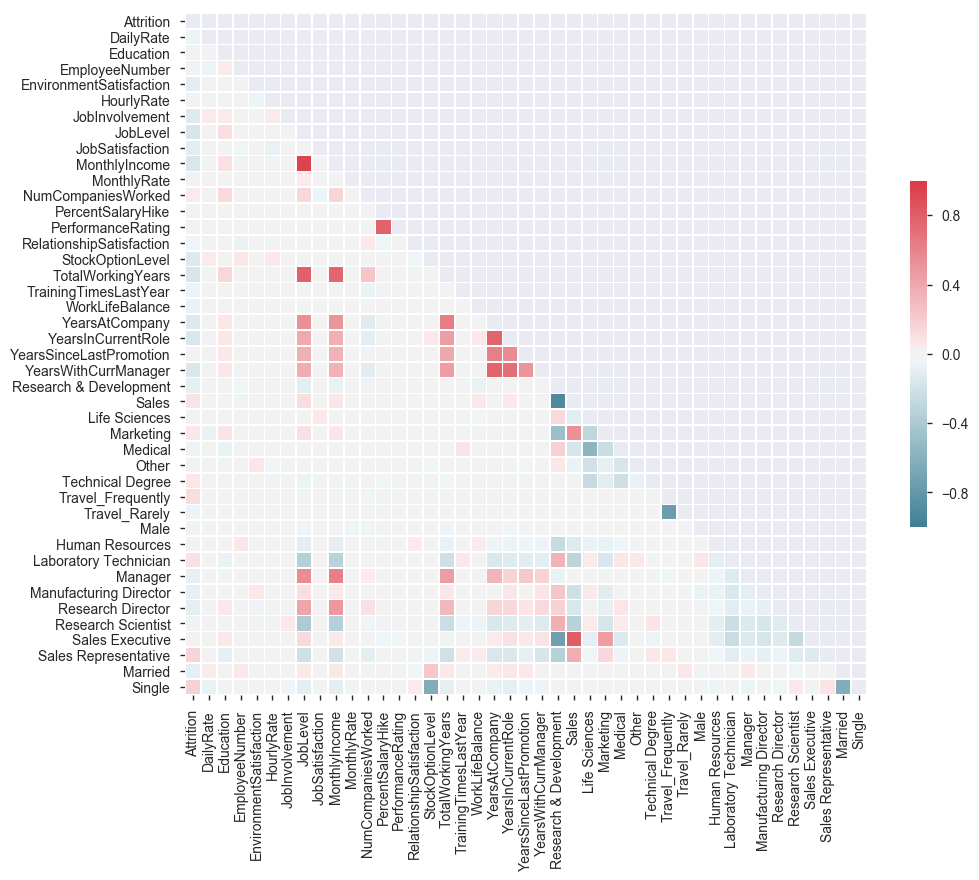

In [51]:
get_collinearity(df)

In [52]:
df = remove_high_corr(df, 0.7, viz=False)


dropping collinear columns ['MonthlyIncome', 'JobLevel', 'MonthlyIncome', 'MonthlyIncome', 'PerformanceRating', 'PerformanceRating', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'YearsAtCompany', 'YearsAtCompany', 'YearsWithCurrManager', 'YearsAtCompany', 'YearsWithCurrManager', 'Sales', 'Sales Executive', 'Sales', 'Sales', 'Travel_Frequently', 'Travel_Frequently', 'Sales Executive', 'Sales']
final columns list:  Index(['Attrition', 'DailyRate', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'Research & Development', 'Life Sciences', 'Marketing', 'Medical',
       'Other', 'Technical Degree', 'Travel_Rarely', 'Male', 'Human Resources',
       'Laboratory Technician

In [53]:
len(df.columns)

35

In [83]:
df.to_csv('numeric_data.csv',index=False)

# Feature Engineering

# Build Model

In [66]:
# downsample to get balanced class for each label
def get_downsample(data, ratio):
# ratio: 0.0 - 1.0
# if 0.6, 60% of final data would be stroke (class 1)   
    data_1 = data[data.Attrition == 1]
    data_0 = data[data.Attrition == 0]
    data_downed = resample(data_0,
                          replace = True,
                          n_samples = int((len(data_1) * (1 - ratio))/ratio))
    
    data_out = pd.concat([data_1, data_downed])
    print('\n Downsampled data')
    print(data_out.groupby('Attrition')['Attrition'].count())
    return data_out 

In [71]:
# currrent class distribution
df.groupby('Attrition')['Attrition'].count()

Attrition
0    1233
1     237
Name: Attrition, dtype: int64

In [72]:
# downsample to balance it
data_dn = get_downsample(df, 0.4)


 Downsampled data
Attrition
0    355
1    237
Name: Attrition, dtype: int64


In [80]:
def try_models(X, y, model_list):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)
    # check balance
    print(y_train.value_counts())
    
    for mod in model_list:
        get_eval_ROC(mod, X_train[X_train.columns[1:]],y_train)
    
        
    best_estimator = randomforestgrid(X_train[X_train.columns[1:]],y_train)
    #knn_est = knngridsearch(10,X_train[X_train.columns[1:]],y_train)  
    log_res = log_cv(X_train[X_train.columns[1:]],y_train)
    return X_train, X_test, y_train, y_test, best_estimator, log_res

def get_eval_ROC(model,X,Y):
    # This will evaluate traning result
    # and present results as the ROC curve
    # X,Y from training set
    kfold = KFold(n_splits=10, random_state=7)
    base_fpr = np.linspace(0, 1, 101)
    
    results = []
    X = np.array(X)
    Y = np.array(Y)
    for i, (train, test) in enumerate(kfold.split(X)):
        y_score = model.fit(X[train], Y[train]).predict_proba(X[test])
        fpr, tpr, _ = roc_curve(Y[test], y_score[:, 1])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        results.append(tpr)

    results = np.array(results)
    mean_results = results.mean(axis=0)
    std = results.std(axis=0)

    res_upper = np.minimum(mean_results + std, 1)
    res_lower = mean_results - std
    print("ROC: %.3f (%.3f)" % (results.mean(), results.std()))
    print("True Positive Rate: %.3f , False Positive Rate: %.3f\n" % (tpr.mean(), fpr.mean()))
    
def select_features(train,y_train):
    X, y = train,y_train
    print('previous shape: ',X.shape)
    clf = ExtraTreesClassifier()
    clf = clf.fit(X, y)
    print(clf.feature_importances_ )
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
    print('new shape: ', X_new.shape)
    return X_new

def randomforestgrid(X,Y):
    rfc = RandomForestClassifier() 
    # Use a grid over parameters of interest
    param_grid = { 
               "n_estimators" : [9, 18, 20],
               "max_depth" : [1, 5, 10, 15],
               "min_samples_leaf" : [1, 2, 4]} 
    print('\n-------------------------')
    print('Starting grid search')
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10,scoring='roc_auc')
    print('fitting')
    CV_rfc.fit(X, Y)
    print('grid search done')
    print('Best params: ', CV_rfc.best_params_)
    print('Best score: ', CV_rfc.best_score_)
    return CV_rfc.best_estimator_

def log_cv(X,y):
    kfold = KFold(n_splits=10, random_state=7)
    searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=10
        ,class_weight='balanced'
    )
    searchCV.fit(X, y)
    print ('Max auc_roc:', searchCV.scores_[1].max())
    print('Best params: ', searchCV.get_params())
    return searchCV
    

def knngridsearch(range_max,X,Y):
    # define the parameter values that should be searched
    # for python 2, k_range = range(1, 31)
    k_range = list(range(1, range_max))
    print(k_range)
    # create a parameter grid: map the parameter names to the values that should be searched
    # simply a python dictionary
    # key: parameter name
    # value: list of values that should be searched for that parameter
    # single key-value pair for param_grid
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)
    # instantiate the grid
    knn = KNeighborsClassifier(n_neighbors = 5)
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='roc_auc')
    # fit the grid with data
    grid.fit(X, Y)
    grid.grid_scores_
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)
    plt.plot(k_range,grid_mean_scores)
    plt.xlabel('Value for K for KNN')
    plt.ylabel('Cross-Validated Accuracy') 
    print('Best params: ', grid.best_params_)
    print('Best score: ', grid.best_score_)
    return grid.best_estimator_

# try scaler
def scale(X, scaler):
    X = X.fillna(0)
    X[['avg_glucose_level', 'bmi']] = scaler.fit_transform(X[['avg_glucose_level', 'bmi']])
    return X

In [74]:
# assign label to new var
y = data_dn['Attrition']
X = data_dn.drop(['Attrition'],axis=1)

In [75]:
# models to try
model1 = LogisticRegression(class_weight='balanced')
model2 = KNeighborsClassifier(n_neighbors=8) 
model3 = RandomForestClassifier(max_depth=2, random_state=0)
model4 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1) 
models = [model1,model2,model3,model4]

In [81]:
X_train, X_test, y_train, y_test, best_estimator, log_est = try_models(X, y, models)

0    255
1    159
Name: Attrition, dtype: int64
ROC: 0.737 (0.254)
True Positive Rate: 0.622 , False Positive Rate: 0.450

ROC: 0.524 (0.312)
True Positive Rate: 0.386 , False Positive Rate: 0.530

ROC: 0.675 (0.267)
True Positive Rate: 0.536 , False Positive Rate: 0.414

ROC: 0.500 (0.292)
True Positive Rate: 0.500 , False Positive Rate: 0.500


-------------------------
Starting grid search
fitting
grid search done
Best params:  {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 18}
Best score:  0.721689040629258
Max auc_roc: 0.8768115942028986
Best params:  {'Cs': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0, 1000000000.0], 'class_weight': 'balanced', 'cv': KFold(n_splits=10, random_state=7, shuffle=False), 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 777, 'refit': True, '

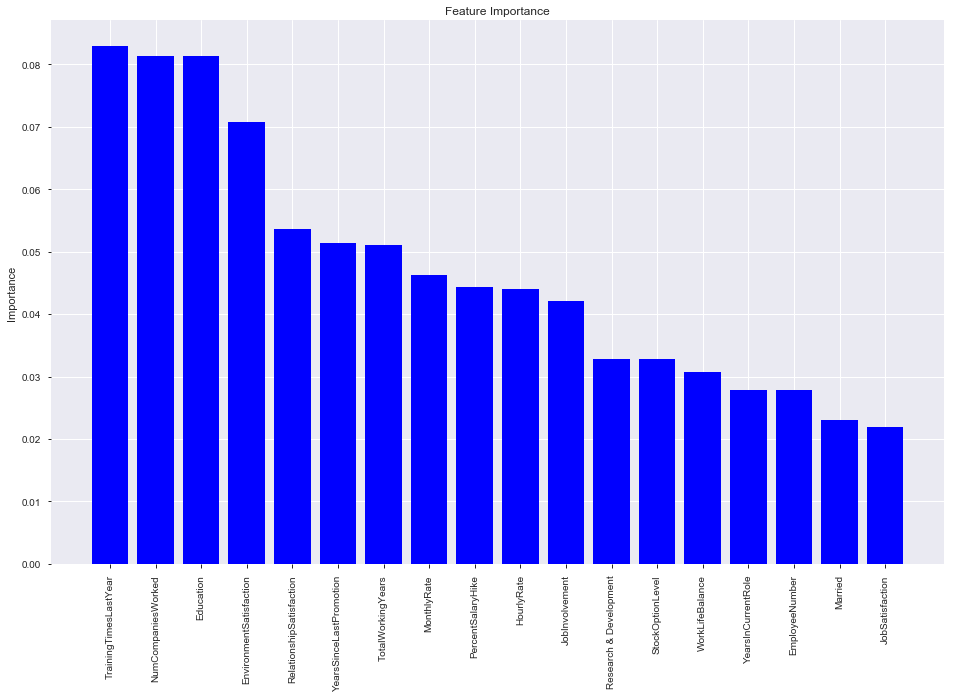

In [87]:
# Feature importance analysis 

rf = RandomForestClassifier(max_depth=10, min_samples_leaf=2, n_estimators=18).fit(X_train,y_train)
importances = rf.feature_importances_
keys = X_train.columns[1:].values
dictionary = dict(zip(keys, importances))
indices = np.argsort(importances)[::-1]
std = np.std([rf.feature_importances_ for f in rf.estimators_],
             axis=0)

import operator
sorted_f = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True)
cols = []
imps = []
for f in sorted_f[:18]:
    col,importance = f
    cols.append(col)
    imps.append(importance)
    
# Plot the feature importaes 
fig = plt.figure(figsize=(16, 10))
y_pos = np.arange(len(cols))
 
plt.bar(y_pos, imps, align='center', color='blue')
plt.xticks(y_pos, cols,rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importance')
 
plt.show()

## Evaluation

In [88]:
# assign label to new var
y = data_dn['Attrition']
X = data_dn.drop(['Attrition'],axis=1)

## Try scaler

In [ ]:
def get_scaled_data(scaler, data_1,data_2):
    data1_scaled= scale(data_1, scaler)
    data2_scaled = scale(data_2, scaler)

    train_1 = data1_scaled[:43400]
    test_1 = data1_scaled[43400:]

    train_2 = data2_scaled[:43400]
    test_2 = data2_scaled[43400:]

    # downsample to get balanced class
    train_dn_1 = get_downsample(train_1, 0.45)
    train_dn_2 = get_downsample(train_2, 0.45)

    train_dn_1 = train_dn_1.drop_duplicates()
    train_dn_2 = train_dn_2.drop_duplicates()

    # drop stroke column in test
    test_1 = test_1.drop(['stroke'],axis=1)
    test_2 = test_2.drop(['stroke'],axis=1)
    return train_dn_1, test_1, train_dn_2, test_2